### Итоговое задание Александра Соколова
### по Проекту 7. Ford vs Ferrari: определяем модель авто по фото
####   Юнит 8. Нейронные сети (отредактирован 13.01.2021)
---

### 1. Импорты, инициализация глобальных констант, контроль инициализации пакетов и оборудования
#### 1.1. Импорты

In [2]:
import os
from datetime import datetime as dt
import numpy as np
import pandas as pd
import math
import sys

import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import Sequential as S
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.1
Keras        : 2.4.0


In [3]:
import utils_module09122020 as utils

In [4]:
from importlib import reload
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:

# import matplotlib.pyplot as plt
# import seaborn as sns
# import pickle
# import zipfile
# import csv

# import os


# import tensorflow as tf
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
# from tensorflow.keras.callbacks import Callback
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras import optimizers
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications.xception import Xception
# from tensorflow.keras.layers import *

# from sklearn.model_selection import train_test_split, StratifiedKFold

# import PIL
# from PIL import ImageOps, ImageFilter
# #увеличим дефолтный размер графиков
# from pylab import rcParams
# rcParams['figure.figsize'] = 10, 5
# #графики в svg выглядят более четкими
# %config InlineBackend.figure_format = 'svg' 
# %matplotlib inline

# print(os.listdir("../input"))
# print('Python       :', sys.version.split('\n')[0])
# print('Numpy        :', np.__version__)
# print('Tensorflow   :', tf.__version__)
# print('Keras        :', tf.keras.__version__)

In [5]:


# import matplotlib.pyplot as plt
# import pickle
# import zipfile
# import csv
# import sys

# from datetime import timedelta, datetime as dt
# from time import time

# import tensorflow as tf
# from tensorflow.keras.preprocessing import image

# from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.callbacks import Callback
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras import optimizers
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications.xception import Xception
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.layers import *
# from tensorflow.keras import Sequential as S
# from sklearn.model_selection import train_test_split
# from tensorflow import keras



# from PIL import ImageOps, ImageFilter
# # Увеличим дефолтный размер графиков
# from pylab import rcParams
# rcParams['figure.figsize'] = 15, 10
# # Улучшим вид графиков в svg
# %config InlineBackend.figure_format = 'svg' 
# %matplotlib inline


# print('Python       :', sys.version.split('\n')[0])
# print('Numpy        :', np.__version__)
# print('Tensorflow   :', tf.__version__)
# print('Keras        :', tf.keras.__version__)

### 1.2. Глобальные константы

In [6]:
# CURRENT_DIR = './'  # имя текущей директории для локальной машины 
CURRENT_DIR = '../'  # имя текущей директории для каггл

# проверка пути в папке input для корректного назначения глобальной константы PATH_TO_FILE
print(os.listdir(CURRENT_DIR+'input/'))

['sf-dl-car-classification', 'result']


In [7]:
PATH_to_FILE = CURRENT_DIR+'input/sf-dl-car-classification/'  # имя директории с исходными файлами
PATH_to_WORKDIR = CURRENT_DIR+'working/'  # имя рабочей директории

RANDOM_SEED = 42  # фиксируем состояние генератора псевдо-случайных чисел для воспроизводимости результата
np.random.seed(RANDOM_SEED)

!pip3 freeze > requirements.txt  # фиксируем версии всех пакетов для воспроизводимости результата

CURRENT_DATE = dt.now().strftime('[%d.%m.%Y]')  # фиксируем текущую дату для контроля версий экспериментов

#### 1.3. Проверка подключения и параметров GPU

In [8]:
!nvidia-smi

Fri Jan 15 20:28:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 2. Импорт и предобработка данных
#### 2.1. Импорт данных

In [9]:
df_train = pd.read_csv(PATH_to_FILE + 'train.csv')
df_submit = pd.read_csv(PATH_to_FILE + 'sample-submission.csv')

#### 2.2. Предобработка данных

In [10]:
# создание в рабочей папке отдельной папки для разъархивированных картинок авто
PATH_to_IMAGES = utils.mkdir(PATH_to_WORKDIR, 'images_of_car') 


Директория с именем (images_of_car) успешно создана в (../working/).
Путь к новой папке (../working/images_of_car/) возвращен в переменную.


In [11]:
utils.unzip(PATH_to_FILE, PATH_to_IMAGES, ['train.zip', 'test.zip'], 'с картинками авто')

Распаковываем zip-архивы с картинками авто:
1. train.zip..................... Распакован.
2. test.zip...................... Распакован.
===
Текущее состояние папки (../working/images_of_car/):= ['test_upload', 'train']


In [12]:
# создаем дополнительные константы для путей к тренировочным и тестовым фото
PATH_to_IMAGES_TRAIN = PATH_to_IMAGES+'train/'
PATH_to_IMAGES_TEST = PATH_to_IMAGES+'test_upload/'

### 3. Разведовательный анализ данных (EDA)
#### 3.1. Статистический анализ

In [13]:
df_train.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [14]:
utils.describe_without_plots_all_collumns(df_train, short=True)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,минимум,среднее,макс,медиана
0,Id,object,15561,0,15561,NaN,NaN,NaN,NaN
1,Category,int64,15561,0,10,0,4.337,9,4


In [15]:
df_train.Category.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

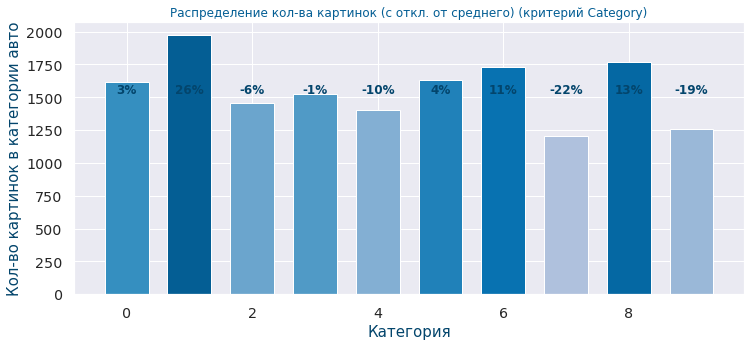

In [16]:
utils.simple_plot_barv('Распределение кол-ва картинок (с откл. от среднего)', 'Category', df_train, 1.3, 'Категория', 'Кол-во картинок в категории авто')


#### 3.2. Визуальный анализ картинок

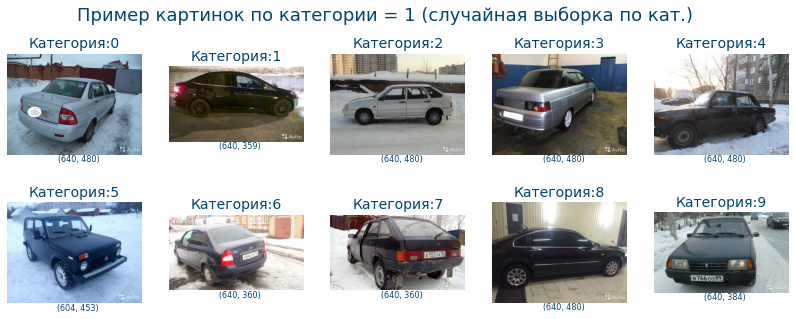

In [17]:
utils.images_from_dataset_with_path('Пример картинок по категории = 1 (случайная выборка по кат.)', 'Категория:',PATH_to_IMAGES+'train/', df_train, 'Category', range(10), 'Id', RANDOM_SEED, True)

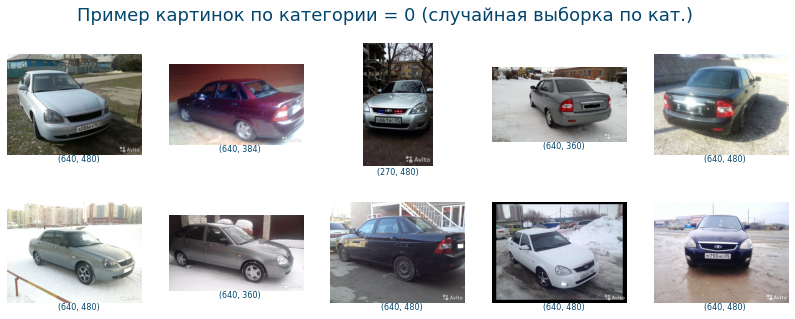

In [18]:
utils.images_from_dataset_with_path('Пример картинок по категории = 0 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.zeros(10, dtype=int), 'Id', RANDOM_SEED+2, False)

0 категория = Lada Priora

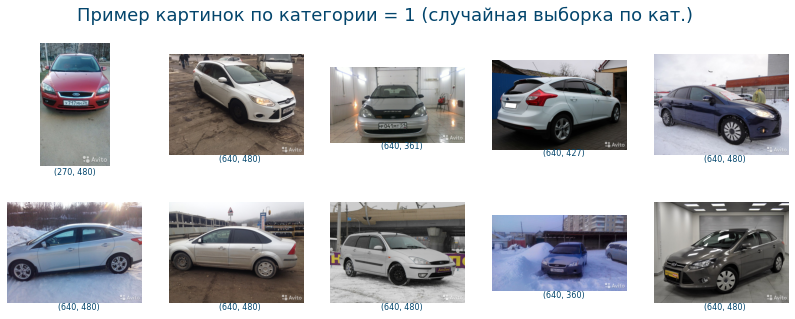

In [19]:
utils.images_from_dataset_with_path('Пример картинок по категории = 1 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int), 'Id', RANDOM_SEED, False)

1 категория = Ford Focus

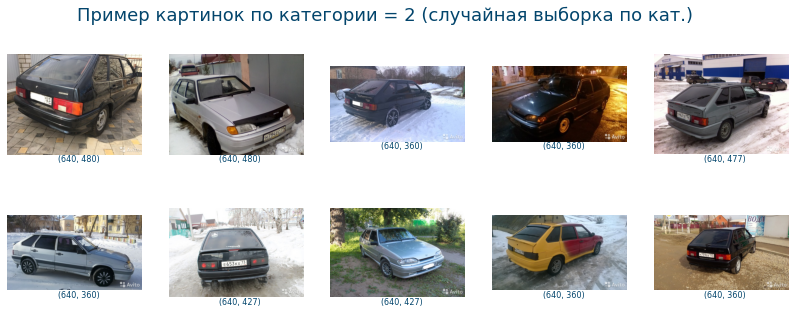

In [20]:
utils.images_from_dataset_with_path('Пример картинок по категории = 2 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*2, 'Id', RANDOM_SEED, False)

2 категория = Lada Samara 2114

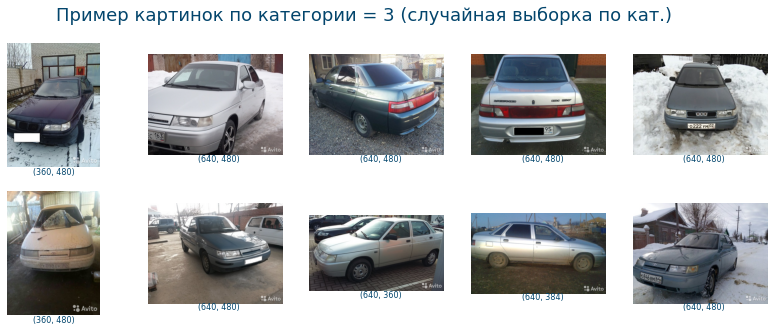

In [21]:
utils.images_from_dataset_with_path('Пример картинок по категории = 3 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*3, 'Id', RANDOM_SEED+1, False)

3 категория = Lada 110

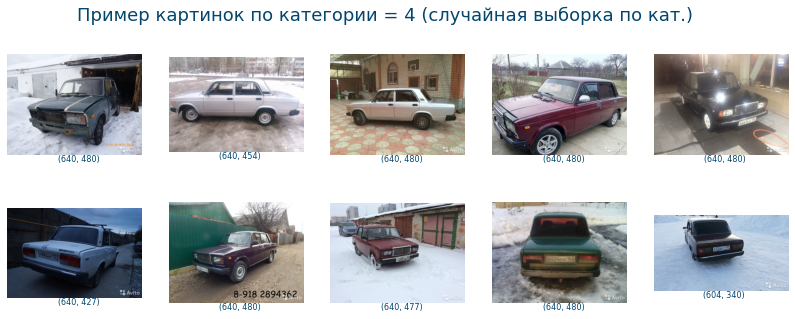

In [22]:
utils.images_from_dataset_with_path('Пример картинок по категории = 4 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*4, 'Id', RANDOM_SEED, False)

4 категория = Lada 2107

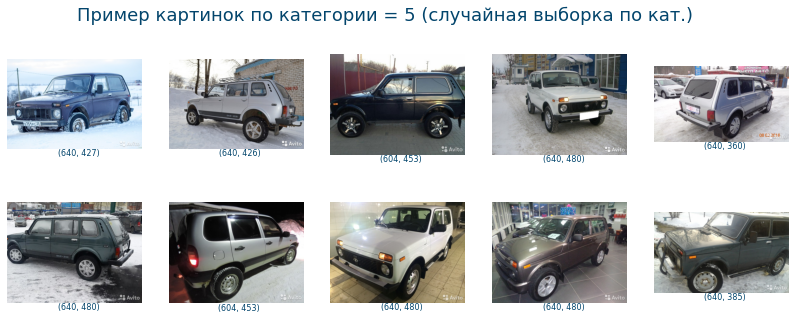

In [23]:
utils.images_from_dataset_with_path('Пример картинок по категории = 5 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*5, 'Id', RANDOM_SEED, False)

5 категория - Lada Niva

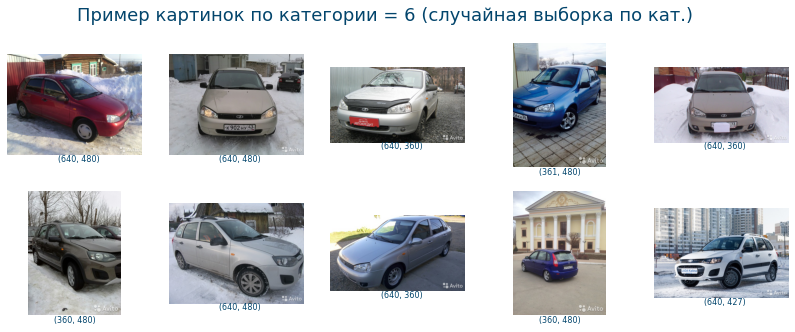

In [24]:
utils.images_from_dataset_with_path('Пример картинок по категории = 6 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*6, 'Id', RANDOM_SEED, False)

6 категория - Lada Kalina

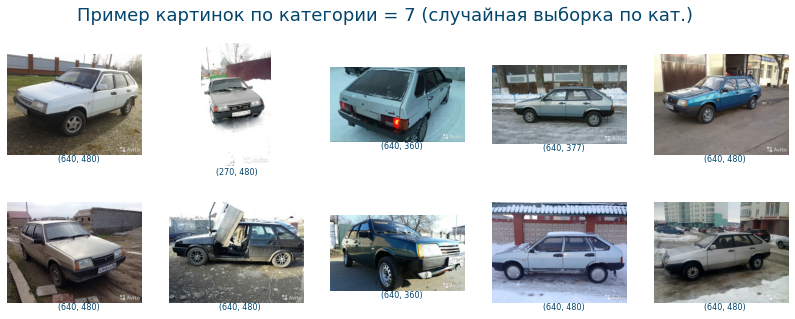

In [25]:
utils.images_from_dataset_with_path('Пример картинок по категории = 7 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*7, 'Id', RANDOM_SEED, False)

7 категория - Lada Samara 2109

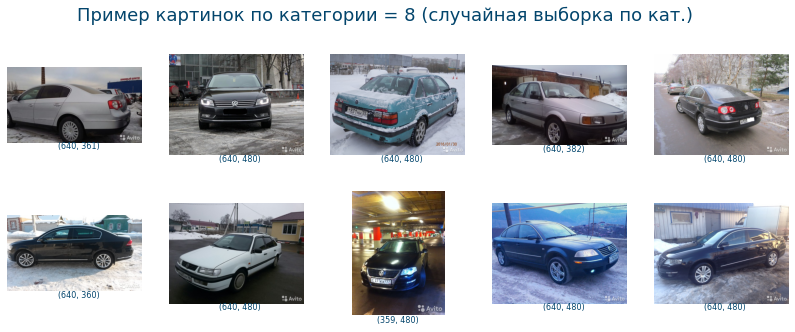

In [26]:
utils.images_from_dataset_with_path('Пример картинок по категории = 8 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*8, 'Id', RANDOM_SEED, False)

8 категория - Volkswagen Passat

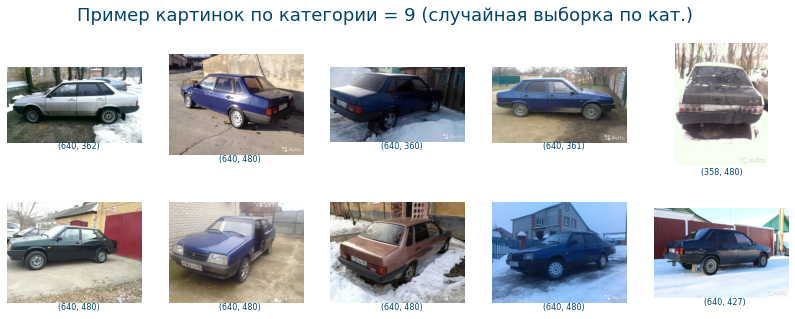

In [27]:
utils.images_from_dataset_with_path('Пример картинок по категории = 9 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*9, 'Id', RANDOM_SEED, False)

9 категория - Lada Samara 21099

Резюме: 
- Для классификации представлены фотографии 10 классов авто Lada
- Категории достаточно сбалансированны
- Размеры фотографий различаются, но в основном 640 на 480. Цветные.
- Всего 15561 фотография (это не достаточно для хорошего обучения модели нейронной сети, поэтому будем применять различные виды аугментации данных)


### 4. Инициализация датасета для хранения ВСЕХ! гиперпараметров и результатов экспериментов
Создание и обучение модели включает в себя:
- аугментацию данных (AUG)
- загрузку основы для модели (M)
- создание архитектуры головы (H)
- предварительное обучение модели (F)
- дообучение модели Fine-tuning (FT)
На каждом этапе нам потребуются какие-то гиперпараметры. К сожалению сохранение модели в формате h5(hdf5) сохраняет только частично информацию с этапов (M) и (H) с обученными весами модели. Мне оказалось этого не достаточно для анализа оптимальных гиперпараметров поэтому я решил создать датасет с результатами экспериментов.  

In [28]:
results_of_exp = pd.DataFrame()  # датафрейм для хранения гиперпараметров и результатов экспериментов
descr_hyperp_of_exp = {}  # словарь для хранения описания гиперпарамметров
NUM_EXP = utils.hyperp('NUM_EXP',1,'Номер эксперимента',results_of_exp,descr_hyperp_of_exp)  # инициализация всех гиперпараметров происходит через специальный метод

NUM_EXP = 1 (Номер эксперимента). Константа инициализирована.


### 5. Предварительная обработка фотографий для обучения модели (препроцессинг)
#### 5.1 Инициализация гиперпараметров для Аугментации фото

In [29]:
AUG_ROTATION_RANGE = utils.hyperp('AUG_ROTATION_RANGE', 5, 'Аугментация. Диапазон для случайных поворотов в градусах',results_of_exp,descr_hyperp_of_exp)
AUG_BRIGHTNES_RANGE = utils.hyperp('AUG_BRIGHTNES_RANGE', [0.5, 1.5], 'Аугментация. Диапазон выбора значения сдвига яркости',results_of_exp,descr_hyperp_of_exp)
AUG_WIDTH_SHIFT_RANGE = utils.hyperp('AUG_WIDTH_SHIFT_RANGE', 0.1, 'Аугментация. Диапазон выбора значения сдвига ширины',results_of_exp,descr_hyperp_of_exp)
AUG_HEIGHT_SHIFT_RANGE = utils.hyperp('AUG_HEIGHT_SHIFT_RANGE', 0.1, 'Аугментация. Диапазон выбора значения сдвига высоты',results_of_exp,descr_hyperp_of_exp)
AUG_HORIZONTAL_FLIP = utils.hyperp('AUG_HORIZONTAL_FLIP', True, 'Аугментация. Логическое значение для произвольного  переворачивания по горизонтали',results_of_exp,descr_hyperp_of_exp)
AUG_RESCALE = utils.hyperp('AUG_RESCALE', 1. / 255, 'Аугментация. Коэффициент масштабирования. Мы умножаем данные на это значение (после применения всех других преобразований)',results_of_exp,descr_hyperp_of_exp)
AUG_VAL_SPLIT = utils.hyperp('AUG_VAL_SPLIT', 0.2, 'Аугментация. Доля выборки оставляемой для валидации вне тренировочной выборки',results_of_exp,descr_hyperp_of_exp)

AUG_IMG_SIZE = utils.hyperp('AUG_IMG_SIZE', 224, 'Аугментация. Размер картинки, которую будем подавать в нейросеть',results_of_exp,descr_hyperp_of_exp)
AUG_BATCH_SIZE = utils.hyperp('AUG_BATCH_SIZE', 64, 'Аугментация. Размер Batch',results_of_exp,descr_hyperp_of_exp)

AUG_ROTATION_RANGE = 5 (Аугментация. Диапазон для случайных поворотов в градусах). Константа инициализирована.
AUG_BRIGHTNES_RANGE = [0.5, 1.5] (Аугментация. Диапазон выбора значения сдвига яркости). Константа инициализирована.
AUG_WIDTH_SHIFT_RANGE = 0.1 (Аугментация. Диапазон выбора значения сдвига ширины). Константа инициализирована.
AUG_HEIGHT_SHIFT_RANGE = 0.1 (Аугментация. Диапазон выбора значения сдвига высоты). Константа инициализирована.
AUG_HORIZONTAL_FLIP = True (Аугментация. Логическое значение для произвольного  переворачивания по горизонтали). Константа инициализирована.
AUG_RESCALE = 0.00392156862745098 (Аугментация. Коэффициент масштабирования. Мы умножаем данные на это значение (после применения всех других преобразований)). Константа инициализирована.
AUG_VAL_SPLIT = 0.2 (Аугментация. Доля выборки оставляемой для валидации вне тренировочной выборки). Константа инициализирована.
AUG_IMG_SIZE = 224 (Аугментация. Размер картинки, которую будем подавать в нейросеть). Конс

##### 5.2 Генерация аугментированных данных

In [30]:
### ЭТУ СТРОКУ НАДО УДАЛИТЬ ИЗ ФИНАЛЬНОЙ ВЕРСИИ НОУТА
reload(utils)

<module 'utils_module09122020' from '/kaggle/usr/lib/utils_module09122020/utils_module09122020.py'>

In [31]:
train_generator, valid_generator, test_generator = utils.train_valid_test_generators(
                    AUG_ROTATION_RANGE,           
                    AUG_BRIGHTNES_RANGE,
                    AUG_WIDTH_SHIFT_RANGE, 
                    AUG_HEIGHT_SHIFT_RANGE,
                    AUG_HORIZONTAL_FLIP,
                    AUG_RESCALE,
                    AUG_VAL_SPLIT,
                    PATH_to_IMAGES_TRAIN,
                    PATH_to_IMAGES_TEST,
                    df_submit,
                    AUG_IMG_SIZE,
                    AUG_BATCH_SIZE,
                    RANDOM_SEED)

AUG_TYPE = utils.hyperp('AUG_TYPE', 'ImageDataGenerator', 'Аугментация. Тип',results_of_exp,descr_hyperp_of_exp)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.
AUG_TYPE = ImageDataGenerator (Аугментация. Тип). Константа инициализирована.


### 6. Создание, предобучение, тонкие настройки и дообучение модели нейросети
#### 6.1 Создание модели
##### 6.1.1 Загрузка предобученной модели

In [32]:
# используем перенос обучения (Transfer learning)
# поэтому сначала загружаем предобученную базовую модель Xception без головы так как будем ставить свою
base_model = Xception(
                    weights='imagenet', 
                    include_top=False, 
                    input_shape = (AUG_IMG_SIZE, AUG_IMG_SIZE, 3))

M_BASE_TYPE = utils.hyperp('M_BASE_TYPE', 'Xception', 'Модель. Тип базовой модели',results_of_exp,descr_hyperp_of_exp)

83689472/83683744 [==============================] - 1s 0us/step
M_BASE_TYPE = Xception (Модель. Тип базовой модели). Константа инициализирована.


##### 6.1.2 Задаем архитектуру головы

In [33]:
H_DROPOUT_RATE =  utils.hyperp('H_DROPOUT_RATE', 0.25, 'Голова модели. Вероятность отключения нейронов в слое Dropout',results_of_exp,descr_hyperp_of_exp)
C_LR = utils.hyperp('C_LR', 1e-4, 'Компиляция модели. Шаг обучения модели',results_of_exp,descr_hyperp_of_exp)
С_OPTIMIZER_TYPE = utils.hyperp('С_OPTIMIZER_TYPE', 'Adam', 'Компиляция модели. Тип оптимайзера',results_of_exp,descr_hyperp_of_exp)
C_LOSS_TYPE = utils.hyperp('C_LOSS_TYPE', 'categorical_crossentropy', 'Компиляция модели. Тип функции потерь (loss-функции)',results_of_exp,descr_hyperp_of_exp)


head = S([GlobalAveragePooling2D(), 
          Dense(256,activation='relu'),
          Dropout(H_DROPOUT_RATE),
          Dense(10, activation='softmax')])
# обратите внимание, что тут повторяется архитектура baseline только без функционального программирования


# Собираем модель используя подход перенос обучения (Transfer learning)
model = utils.model_assembler(base_model, head)

# Компилируем модель
model.compile(loss=C_LOSS_TYPE, 
              optimizer=optimizers.Adam(lr=C_LR), 
              metrics=['accuracy'])

H_DROPOUT_RATE = 0.25 (Голова модели. Вероятность отключения нейронов в слое Dropout). Константа инициализирована.
C_LR = 0.0001 (Компиляция модели. Шаг обучения модели). Константа инициализирована.
С_OPTIMIZER_TYPE = Adam (Компиляция модели. Тип оптимайзера). Константа инициализирована.
C_LOSS_TYPE = categorical_crossentropy (Компиляция модели. Тип функции потерь (loss-функции)). Константа инициализирована.


In [34]:
utils.model_summary_short(model)

Краткая информация о модели:
===
Всего параметров: 21388594
Тренируемых параметров: 21334066
Нетренируемых параметров: 54528


##### 6.1.3 Обучение модели
###### 6.1.3.1 Гиперпараметры обучения модели

In [35]:
results_of_exp

,NUM_EXP,AUG_ROTATION_RANGE,AUG_BRIGHTNES_RANGE,AUG_WIDTH_SHIFT_RANGE,AUG_HEIGHT_SHIFT_RANGE,AUG_HORIZONTAL_FLIP,AUG_RESCALE,AUG_VAL_SPLIT,AUG_IMG_SIZE,AUG_BATCH_SIZE,AUG_TYPE,M_BASE_TYPE,H_DROPOUT_RATE,C_LR,С_OPTIMIZER_TYPE,C_LOSS_TYPE
0,1,5,"[0.5, 1.5]",0.1,0.1,True,0.00392157,0.2,224,64,ImageDataGenerator,Xception,0.25,0.0001,Adam,categorical_crossentropy


In [36]:
M_EPOCHS = utils.hyperp('M_EPOCHS', 5, 'Модель. Кол-во эпох обучения модели',results_of_exp,descr_hyperp_of_exp)

M_CALLBACKS_TYPE = utils.hyperp('M_CALLBACKS_TYPE', 'MC_T', 'Модель. Тип callback: MC - ModelCheckpoint, ES - EarlyStopping, LRS - LearningRateScheduler, T - Time Callbacks',results_of_exp,descr_hyperp_of_exp)
M_EPOCHS_DROP = utils.hyperp('M_EPOCHS_DROP', 3, 'Модель. Кол-во эпох через которое LR изменяется внутри функции sheduler',results_of_exp,descr_hyperp_of_exp)
M_LR_UPDATE = utils.hyperp('M_LR_UPDATE', math.exp(-0.1), 'Модель. Коэфф изменения LR функции sheduler',results_of_exp,descr_hyperp_of_exp)

M_EPOCHS = 5 (Модель. Кол-во эпох обучения модели). Константа инициализирована.
M_CALLBACKS_TYPE = MC_T (Модель. Тип callback: MC - ModelCheckpoint, ES - EarlyStopping, LRS - LearningRateScheduler, T - Time Callbacks). Константа инициализирована.
M_EPOCHS_DROP = 3 (Модель. Кол-во эпох через которое LR изменяется внутри функции sheduler). Константа инициализирована.
M_LR_UPDATE = 0.9048374180359595 (Модель. Коэфф изменения LR функции sheduler). Константа инициализирована.


###### 6.1.3.2 Инициализация Callbacks и обучение модели

In [37]:
time_cb = utils.TimingCallback()
callbacks_list = utils.callbacks_assembler(M_CALLBACKS_TYPE, 
                                           C_LR, 
                                           M_LR_UPDATE, 
                                           M_EPOCHS_DROP, 
                                           time_cb)

history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = valid_generator, 
        validation_steps = len(valid_generator),
        epochs = M_EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5
195/195 [==============================] - ETA: 0s - loss: 0.9148 - accuracy: 0.6852
Epoch 00001: val_accuracy improved from -inf to 0.87842, saving model to best_model.hdf5
195/195 [==============================] - 348s 2s/step - loss: 0.9148 - accuracy: 0.6852 - val_loss: 0.3392 - val_accuracy: 0.8784
Epoch 2/5
195/195 [==============================] - ETA: 0s - loss: 0.2262 - accuracy: 0.9211
Epoch 00002: val_accuracy improved from 0.87842 to 0.91830, saving model to best_model.hdf5
195/195 [==============================] - 344s 2s/step - loss: 0.2262 - accuracy: 0.9211 - val_loss: 0.2395 - val_accuracy: 0.9183
Epoch 3/5
195/195 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9498
Epoch 00003: val_accuracy did not improve from 0.91830
195/195 [==============================] - 335s 2s/step - loss: 0.1377 - accuracy: 0.9498 - val_loss: 0.2582 - val_accuracy: 0.9125
Epoch 4/5
195/195 [==============================] - ETA: 0s - loss: 0.0947 - accur

###### 6.1.3.3 Сохранение результатов обучения модели

In [ ]:
PATH_to_RESULTS = utils.mkdir(PATH_to_WORKDIR, 'results_of_model_fit') 

In [ ]:
utils.save_model(PATH_to_RESULTS, history, time_cb, results_of_exp,descr_hyperp_of_exp)
# метод записывает результаты обучения модели в датасет с результатами
# также сохраняет дату и время и эксперимента
# загружает в модель лучшую, сохраняет ее с именем номера эксперимента, даты и времени

6.1.3.4 Визуализация результатов обучения модели

In [5]:
results_of_exp = pd.read_csv('../input/result/results_1_20210115__20_58.csv')

<Figure size 864x432 with 0 Axes>

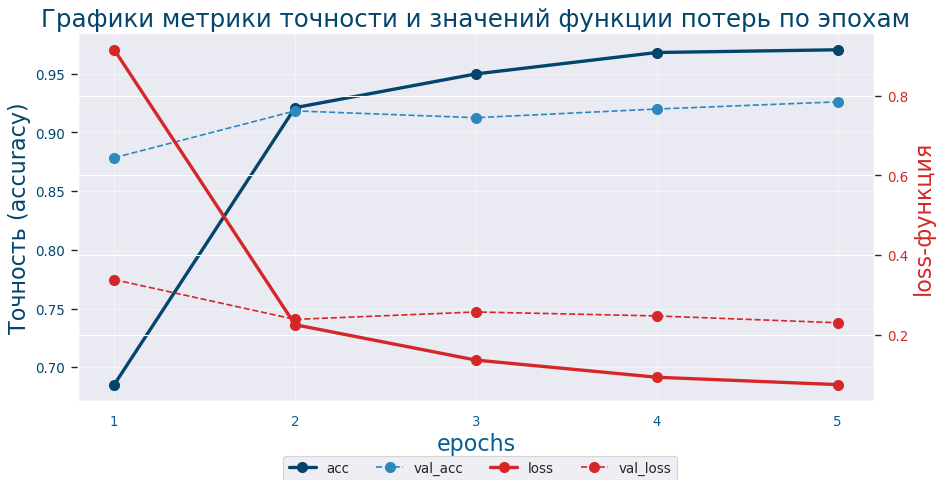

In [6]:
utils.plot_acc_loss_fit_model_in_one (1, results_of_exp)

Это пример на базе baseline с которого начались многочисленные эксперименты по выбору базовой модели и оптимальных предварительных параметров для того чтобы перейти к тонкой настройке (Fine_Tuning). Эксперименты проводились в отдельном ноутбуке (ссылка)[] для удобства.

#### 6.2 Transfer learning с Fine-tuning
##### 6.2.1 Шаг 1. Замораживаем базовую часть модели полностью
##### 6.2.2 Шаг 2. Разморозка половины слоев базовой модели + уменьшаем шаг обучения
##### 6.2.3 Шаг 3. Разморозка всех слоев базовой модели + уменьшаем шаг обучения
#### 6.3 Дообучение модели на увеличенном размере изображения

### 7. Формируем файл с предсказанием на тесте
#### 7.1. Предсказание без TTA

#### 7.2. Предсказание c TTA